<a href="https://colab.research.google.com/github/nourwalid70/Augmented-reality-and-image-mosaics/blob/main/Lab_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2 
from math import ceil
import math
from google.colab.patches import cv2_imshow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_correspondences(book_frame, des_cover):
  sift = cv2.SIFT_create()
  # Applying SIFT detector for first frame
  kp_frame, des_frame = sift.detectAndCompute(book_frame,None)
  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des_cover,des_frame,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])

  # sort acsendingly by matching distance and take top 50 correspondences
  good = sorted(good, key=lambda x: x[0].distance)[:50]
  return good, kp_frame, des_frame

In [ ]:
def calc_homography(pts_src, pts_dst):
  n = len(pts_src)

  x = pts_src[:, 0]
  y = pts_src[:, 1]
  x_ = pts_dst[:, 0]
  y_ = pts_dst[:, 1]

  A = np.zeros((2*n, 9))

  A[::2, 0] = -1*x
  A[::2, 1] = -1*y
  A[::2, 2] = -1
  A[::2, 3:6] = 0
  A[::2, 6] = x * x_
  A[::2, 7] = y * x_
  A[::2, 8] = x_
  
  A[1::2, 0:3] = 0
  A[1::2, 3] = -1 * x
  A[1::2, 4] = -1 * y
  A[1::2, 5] = -1
  A[1::2, 6] = x * y_
  A[1::2, 7] = y * y_
  A[1::2, 8] = y_

  _, _, VT = np.linalg.svd(A)  # sigma is sorted descendingly
  v_i = VT[-1]  # the column corresponding to the smallest singlur value
  h = v_i.reshape(3, 3)
  h = h / h[-1, -1]

  return h

In [ ]:
def ransac(calc_homography, pts_src, pts_dst):

  '''
    Applies RANSAC algorithm on the set of input matching points.
    params: 
      calc_homography: a function that calculates the homography matrix
      pts_src: list of points from the source image (book_cover)
      pts_dst: list of points from the destination image (book_frame)
    returns:
      best_pts_src: set of inliers from pts_src
      best_pts_dst: set of inliers from pts_dst
  '''

  point_count = len(pts_src)
  pts_src, pts_dst = np.array(pts_src), np.array(pts_dst)

  ones = np.ones([point_count, 1])
  pts_src = np.append(pts_src, ones, axis=1)
  pts_dst = np.append(pts_dst, ones, axis=1)

  max_inliers = 0
  best_error = 0
  num_iter = 100
  tol = 5
  for i in range(num_iter):
      rand_matches = np.random.permutation(point_count)[:4]
      p1 = pts_src[rand_matches]
      p2 = pts_dst[rand_matches]
      H = calc_homography(p1, p2)  # model

      pts_src_transformed = (H @ pts_src.T).T
      pts_src_transformed = pts_src_transformed / pts_src_transformed[:, -1].reshape(-1, 1)
      
      error = (np.square((pts_src_transformed - pts_dst)).sum(axis=1) < tol).astype('int')
      inliers = error.sum()
      if inliers > max_inliers:
          max_inliers = inliers
          best_error = error

  best_pts_src = pts_src[np.where(best_error==True)][:, :-1]
  best_pts_dst = pts_dst[np.where(best_error==True)][:, :-1]

  return best_pts_src, best_pts_dst

In [ ]:
def get_correspondences_points(good, kp_cover, kp_frame):
  '''
    Gets the coordinates of matching pairs from book_cover and book_frame.
    params: 
      good: list of DMatch objects of the best 50 correspondences
      kp_cover: list of keypoints of book_cover
      kp_frame: list of keypoints of book_frame
    returns:
      pts_src: list of points from the source image (book_cover)
      pts_dst: list of points from the destination image (book_frame)
  '''
  pts_src, pts_dst = [], []
  for g in good:
    pts_src.append(list(kp_cover[g[0].queryIdx].pt))
    pts_dst.append(list(kp_frame[g[0].trainIdx].pt))

  pts_src = np.array(pts_src)
  pts_dst = np.array(pts_dst)
  return pts_src, pts_dst

In [ ]:
def get_image_key_points_with_img(img):
  sift = cv2.SIFT_create()
  kp, des = sift.detectAndCompute(img,None)
  return kp, des

# Part 2

In [ ]:
pano_1_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/pano_image1.jpg'
pano_2_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/pano_image2.jpg'
img_1 = cv2.imread(pano_1_path)
img_2 = cv2.imread(pano_2_path)

In [ ]:
kp_1,des_1=get_image_key_points_with_img(img_1)


In [ ]:
good,kp_2,des_2=get_correspondences(img_2,des_1)

pts_src, pts_dst = get_correspondences_points(good, kp_1, kp_2)
pts_src, pts_dst = ransac(calc_homography, pts_src, pts_dst) 
h2 = calc_homography(pts_src, pts_dst) 
print(pts_src.shape, pts_dst.shape)

(50, 2) (50, 2)


In [ ]:
h2

array([[ 7.57133439e-01,  3.98552847e-02,  4.47111178e+02],
       [-1.38406795e-01,  9.10754143e-01,  7.67278963e+01],
       [-2.17984899e-04, -3.10759180e-05,  1.00000000e+00]])

In [ ]:
homography, _ = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
print(f'verify result with cv2.findHomography: \n{homography}')

verify result with cv2.findHomography: 
[[ 7.57467213e-01  4.01733400e-02  4.47045687e+02]
 [-1.38341346e-01  9.11240746e-01  7.66052939e+01]
 [-2.17792286e-04 -3.06970047e-05  1.00000000e+00]]


In [ ]:
img_final = cv2.warpPerspective(img_1,homography,(1650,750))

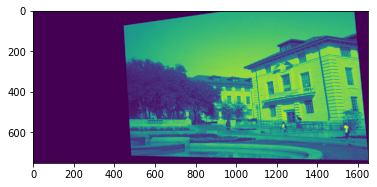

In [ ]:
plt.imshow(img_final[:,:,0])

In [ ]:
img_1_b,img_1_g,img_1_r = cv2.split(img_1)

In [ ]:
left, up = 0, 0
right, down = img_1.shape[1], img_1.shape[0]

In [ ]:
def new_coord(x,y,H):
  old_point = np.zeros((3,1))
  old_point[0,0]=x
  old_point[1,0]=y
  old_point[2,0]=1
  new_point = H.dot(old_point)
  new_point /=new_point[2,0]
  new_x=round(new_point[1,0])
  new_y=round(new_point[0,0])
  return new_x,new_y

In [ ]:
height_max = max(new_coord(left, up, h2)[0], new_coord(left, down, h2)[0], new_coord(right, up, h2)[0], new_coord(right, down, h2)[0])
width_max = max(new_coord(left, up, h2)[1], new_coord(left, down, h2)[1], new_coord(right, up, h2)[1], new_coord(right, down, h2)[1])
height_min = min(new_coord(left, up, h2)[0], new_coord(left, down, h2)[0], new_coord(right, up, h2)[0], new_coord(right, down, h2)[0])
width_min = min(new_coord(left, up, h2)[1], new_coord(left, down, h2)[1], new_coord(right, up, h2)[1], new_coord(right, down, h2)[1])


In [ ]:
height_max

737

In [ ]:
img_final_b = np.zeros((height_max,width_max))
img_final_g = np.zeros((height_max,width_max))
img_final_r = np.zeros((height_max,width_max))

In [ ]:
w = img_1.shape[0]
h = img_1.shape[1]
for y in range(w):
    for x in range(h):
        new_x,new_y=new_coord(x,y,h2)
        if(new_x>=0 and new_y>=0):
          img_final_b[new_x,new_y] = img_1_b[y,x]
          img_final_g[new_x,new_y] = img_1_g[y,x]
          img_final_r[new_x,new_y] = img_1_r[y,x] 

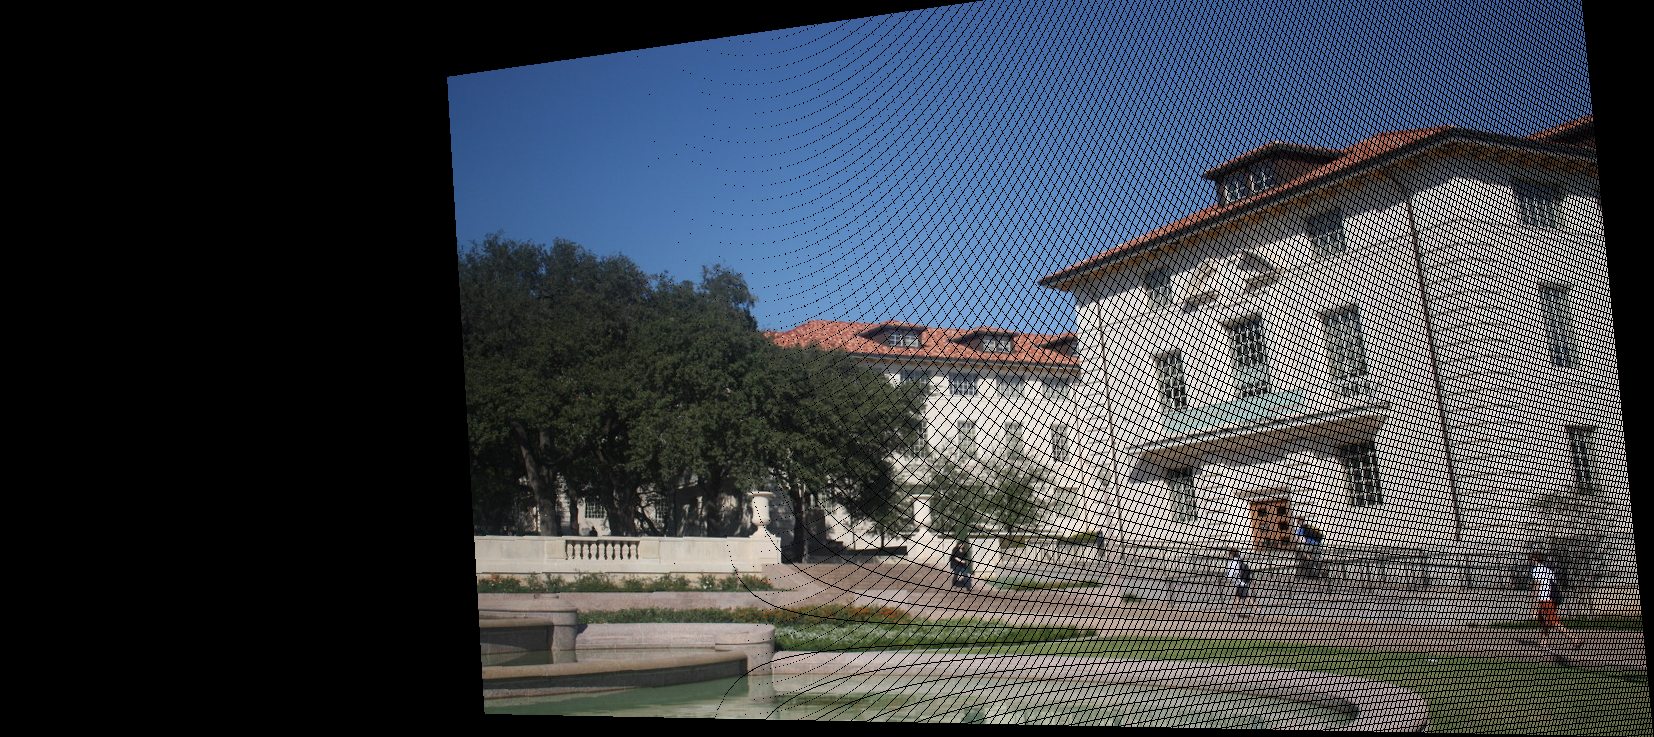

In [ ]:
img_final=cv2.merge([img_final_b,img_final_g,img_final_r])
cv2_imshow(img_final)

In [ ]:
inv_h=np.linalg.inv(h2)

In [ ]:
import math

for y in range(0,height_max):
  for x in range(width_min,width_max):
    if(img_final[y,x,0]==0):
      new_x,new_y=new_coord(x,y,inv_h)
      if(new_x>-1 and new_x<=down-1 and new_y>-1 and new_y<=right-1):
        floor_x= math.floor(new_x)
        floor_y=math.floor(new_y)
        ceil_x=math.ceil(new_x)
        ceil_y=math.ceil(new_y)
        top_left = img_1[floor_x][floor_y]
        top_right = img_1[floor_x][ceil_y]
        bot_left = img_1[ceil_x][floor_y]
        bot_right = img_1[ceil_x][ceil_y]
        top=top_left*(1-(new_y-floor_y))+top_right*(new_y-floor_y)
        bot=bot_left*(1-(new_y-floor_y))+bot_right*(new_y-floor_y)
        v=top*(1-(new_x-floor_x))+bot*(new_x-floor_x)
        img_final[y,x]= v

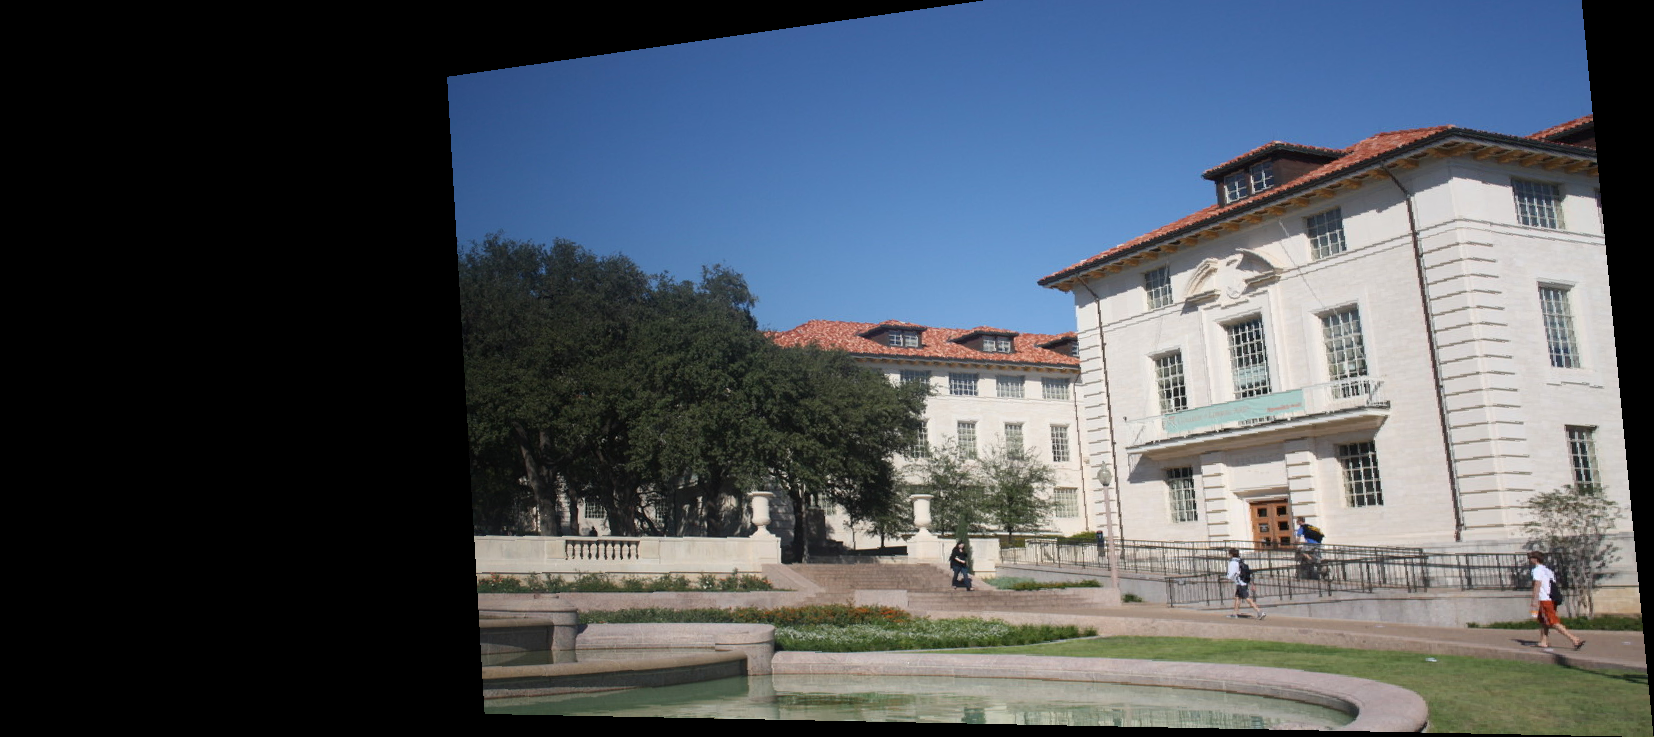

In [ ]:
cv2_imshow(img_final)

(683, 1024, 3) (683, 1024, 3)


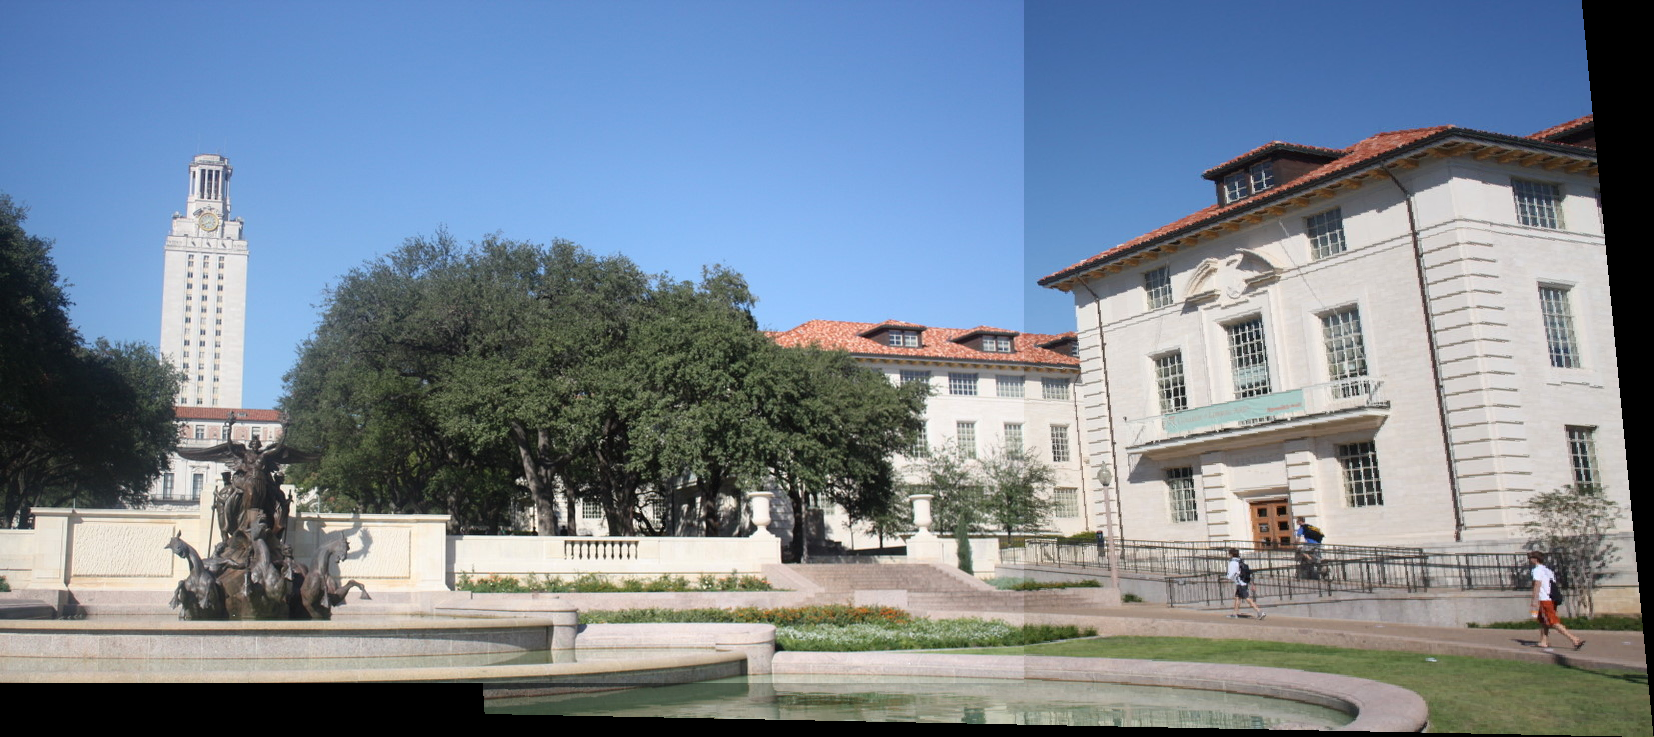

In [ ]:
rows,cols,channels = img_2.shape
roi = img_final[0:rows, 0:cols]
# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img_2,img_2,mask = mask)
# Put logo in ROI and modify the main image
print(img1_bg.shape,img2_fg.shape)
dst = cv2.add(img1_bg,img2_fg,dtype=cv2.CV_64F)
img_final[0:rows, 0:cols ] = dst
cv2_imshow(img_final)



# Bonus


In [ ]:
bonus_1_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/shanghai-21.png'
bonus_2_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/shanghai-22.png'
bonus_3_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/shanghai-23.png'
img_1 = cv2.imread(bonus_1_path)
img_2 = cv2.imread(bonus_2_path)
img_3 = cv2.imread(bonus_3_path)

In [ ]:
kp_1,des_1=get_image_key_points_with_img(img_1)

In [ ]:
good,kp_2,des_2=get_correspondences(img_2,des_1)

pts_src, pts_dst = get_correspondences_points(good, kp_1, kp_2)
pts_src, pts_dst = ransac(calc_homography, pts_src, pts_dst) 
h2 = calc_homography(pts_src, pts_dst) 
print(pts_src.shape, pts_dst.shape)

(47, 2) (47, 2)


In [ ]:
h2 = calc_homography(pts_src, pts_dst)
h2

array([[ 9.68416110e-01, -4.55962353e-02,  4.29337525e+01],
       [-2.30393553e-03,  9.37199418e-01,  2.00766956e+02],
       [-1.12410158e-05, -7.63653757e-05,  1.00000000e+00]])

In [ ]:
img_1_b,img_1_g,img_1_r = cv2.split(img_1)

In [ ]:
left, up = 0, 0
right, down = img_1.shape[1], img_1.shape[0]

In [ ]:
height_max = max(new_coord(left, up, h2)[0], new_coord(left, down, h2)[0], new_coord(right, up, h2)[0], new_coord(right, down, h2)[0])
width_max = max(new_coord(left, up, h2)[1], new_coord(left, down, h2)[1], new_coord(right, up, h2)[1], new_coord(right, down, h2)[1])
height_min = min(new_coord(left, up, h2)[0], new_coord(left, down, h2)[0], new_coord(right, up, h2)[0], new_coord(right, down, h2)[0])
width_min = min(new_coord(left, up, h2)[1], new_coord(left, down, h2)[1], new_coord(right, up, h2)[1], new_coord(right, down, h2)[1])


In [ ]:
img_final_b = np.zeros((height_max,width_max))
img_final_g = np.zeros((height_max,width_max))
img_final_r = np.zeros((height_max,width_max))

In [ ]:
w = img_1.shape[0]
h = img_1.shape[1]
for y in range(w):
    for x in range(h):
        new_x,new_y=new_coord(x,y,h2)
        if(new_x>-1 and new_y>-1):
          img_final_b[new_x,new_y] = img_1_b[y,x]
          img_final_g[new_x,new_y] = img_1_g[y,x]
          img_final_r[new_x,new_y] = img_1_r[y,x] 

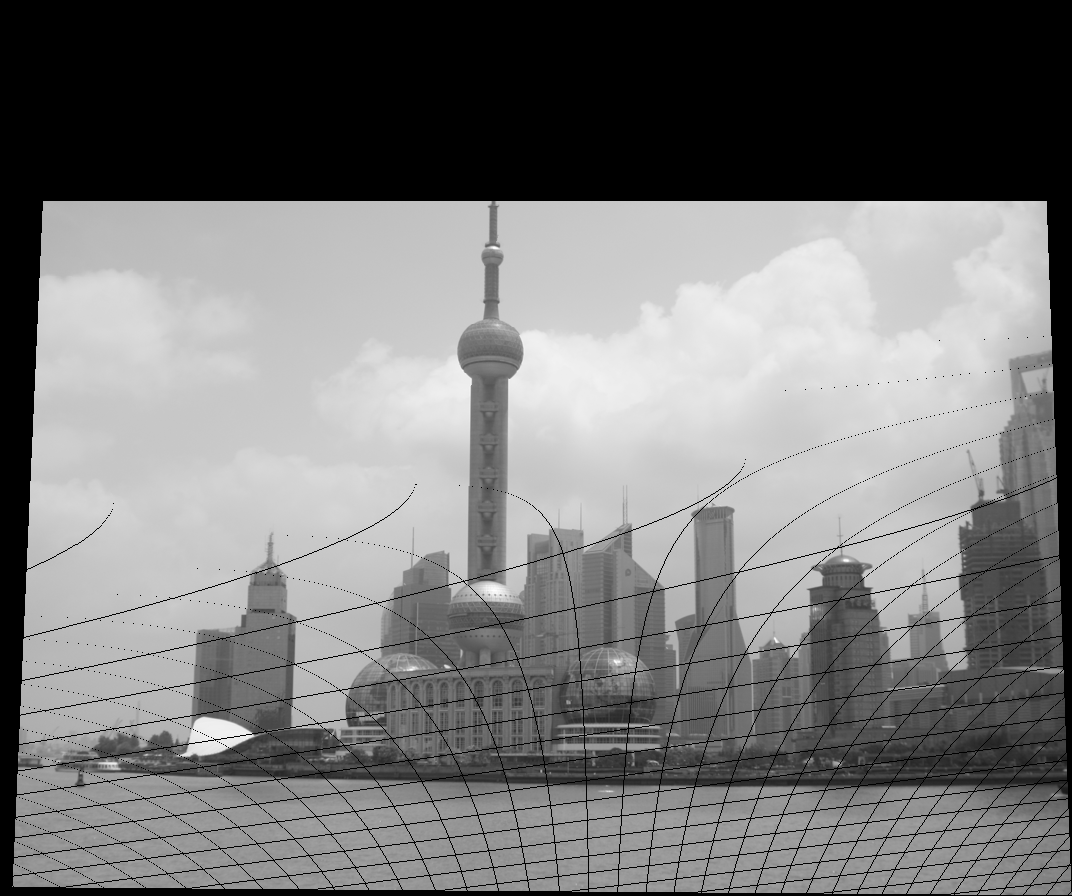

In [ ]:
img_final=cv2.merge([img_final_b,img_final_g,img_final_r])
cv2_imshow(img_final)

In [ ]:
inv_h=np.linalg.inv(h2)

In [ ]:
import math

for y in range(0,height_max):
  for x in range(width_min,width_max):
    if(img_final[y,x,0]==0):
      new_x,new_y=new_coord(x,y,inv_h)
      if(new_x>-1 and new_x<=down-1 and new_y>-1 and new_y<=right-1):
        floor_x= math.floor(new_x)
        floor_y=math.floor(new_y)
        ceil_x=math.ceil(new_x)
        ceil_y=math.ceil(new_y)
        top_left = img_1[floor_x][floor_y]
        top_right = img_1[floor_x][ceil_y]
        bot_left = img_1[ceil_x][floor_y]
        bot_right = img_1[ceil_x][ceil_y]
        delta_x = new_x-floor_x
        delta_y = new_x-floor_x
        top=top_left*delta_y+top_right*(1-delta_y)
        bot=bot_left*delta_y+bot_right*(1-delta_y)
        v=top*delta_x+bot*(1-delta_y)
        img_final[y,x]= v

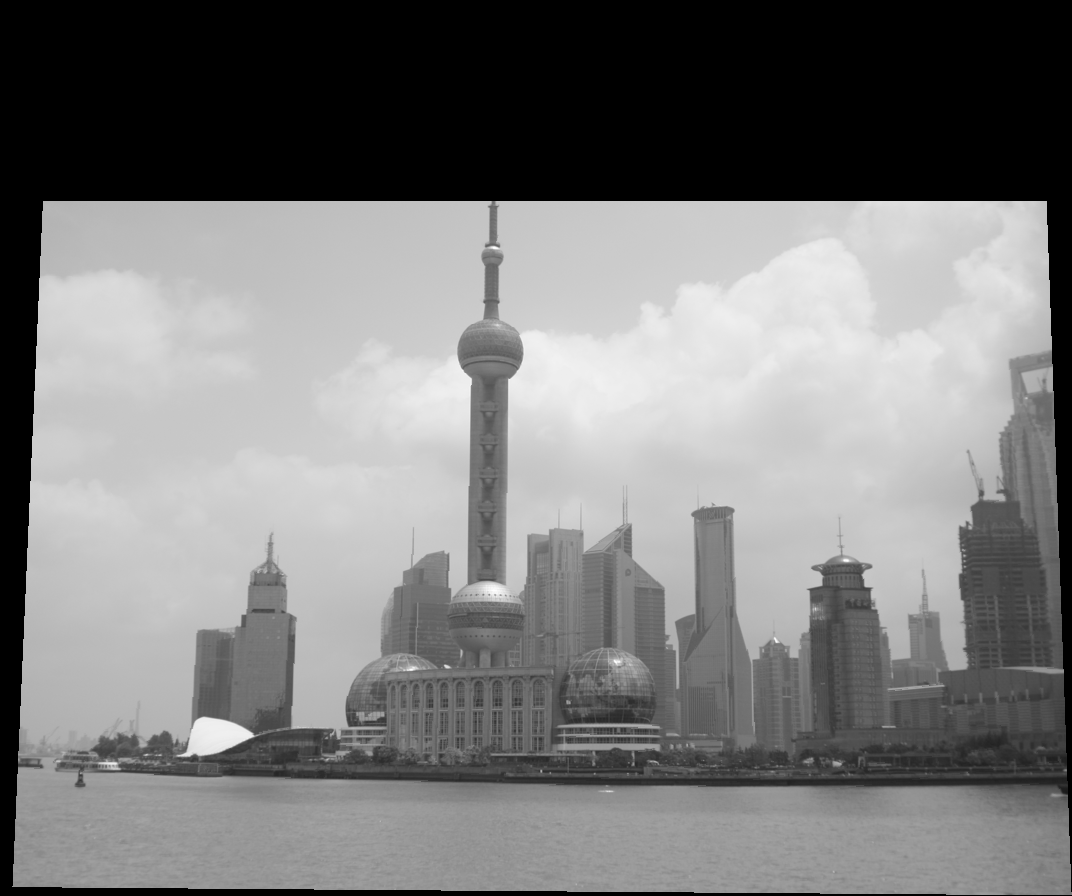

In [ ]:
cv2_imshow(img_final)

(683, 1024, 3) (683, 1024, 3)


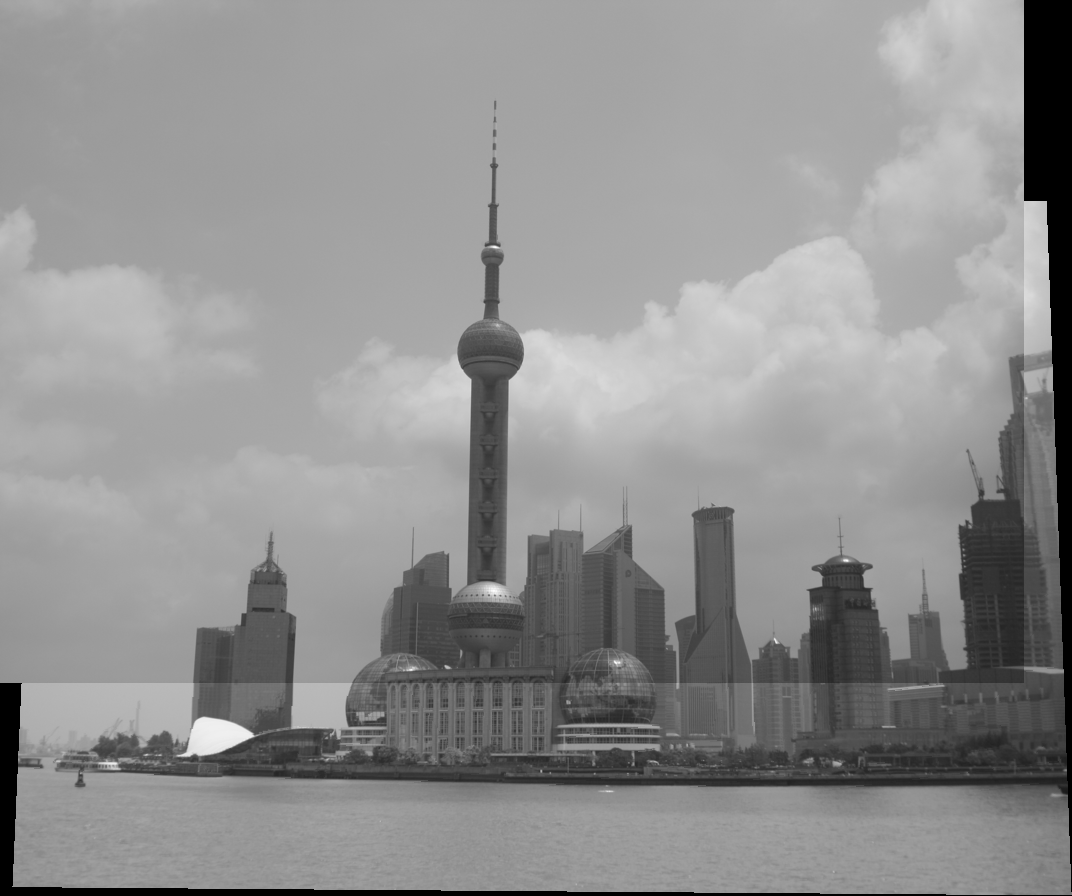

In [ ]:
rows,cols,channels = img_2.shape
roi = img_final[0:rows, 0:cols]
# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img_2,img_2,mask = mask)
# Put logo in ROI and modify the main image
print(img1_bg.shape,img2_fg.shape)
dst = cv2.add(img1_bg,img2_fg,dtype=cv2.CV_64F)
img_final[0:rows, 0:cols ] = dst
cv2_imshow(img_final)



In [ ]:
kp_3,des_3=get_image_key_points_with_img(img_3)


In [ ]:
img_final = cv2.normalize(img_final, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [ ]:
good,kp_2,des_2=get_correspondences(img_final,des_3)

pts_src, pts_dst = get_correspondences_points(good, kp_3, kp_2)
pts_src, pts_dst = ransac(calc_homography, pts_src, pts_dst) 
h3 = calc_homography(pts_src, pts_dst) 
print(pts_src.shape, pts_dst.shape)


(48, 2) (48, 2)


In [ ]:
h3

array([[ 8.62334242e-01, -1.74597127e-02,  3.72380844e+02],
       [-9.68479762e-02,  8.97710117e-01,  2.39509811e+02],
       [-1.14363505e-04, -8.34571371e-05,  1.00000000e+00]])

In [ ]:
img_3_b,img_3_g,img_3_r = cv2.split(img_3)

In [ ]:
left, up = 0, 0
right, down = img_3.shape[1], img_3.shape[0]

In [ ]:
down

683

In [ ]:
height_max = max(new_coord(left, up, h3)[0], new_coord(left, down, h3)[0], new_coord(right, up, h3)[0], new_coord(right, down, h3)[0])
width_max = max(new_coord(left, up, h3)[1], new_coord(left, down, h3)[1], new_coord(right, up, h3)[1], new_coord(right, down, h3)[1])
height_min = min(new_coord(left, up, h3)[0], new_coord(left, down, h3)[0], new_coord(right, up, h3)[0], new_coord(right, down, h3)[0])
width_min = min(new_coord(left, up, h3)[1], new_coord(left, down, h3)[1], new_coord(right, up, h3)[1], new_coord(right, down, h3)[1])


In [ ]:
img_final2_b = np.zeros((height_max,width_max))
img_final2_g = np.zeros((height_max,width_max))
img_final2_r = np.zeros((height_max,width_max))

In [ ]:
width_max

1506

In [ ]:
w = img_3.shape[0]
h = img_3.shape[1]
for y in range(w):
    for x in range(h):
        new_x,new_y=new_coord(x,y,h3)
        if(new_x>-1 and new_y>-1):
          img_final2_b[new_x,new_y] = img_3_b[y,x]
          img_final2_g[new_x,new_y] = img_3_g[y,x]
          img_final2_r[new_x,new_y] = img_3_r[y,x] 

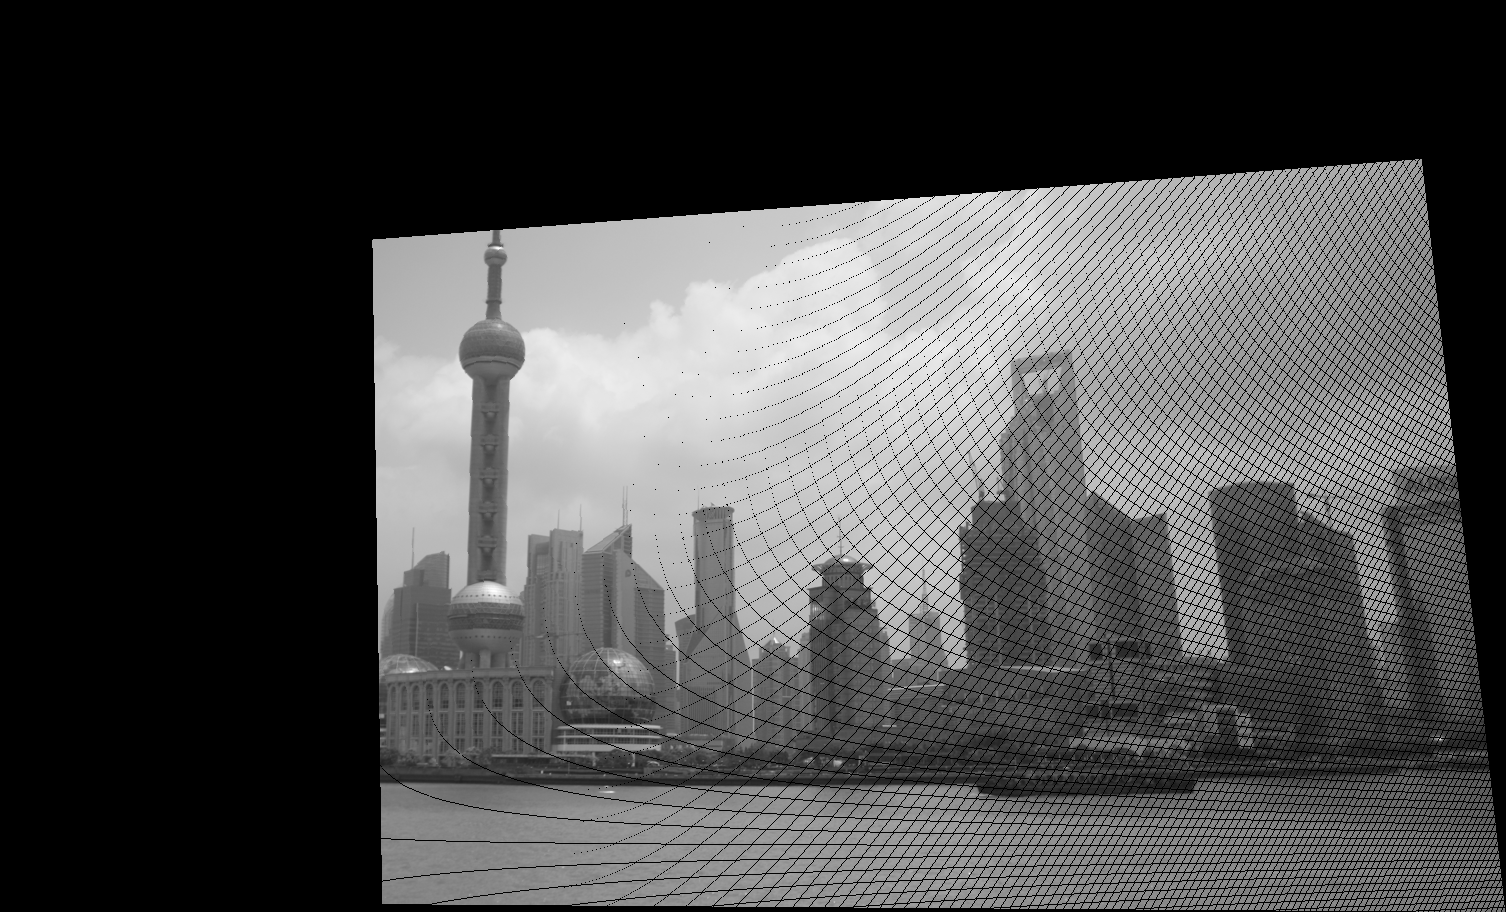

In [ ]:
img_final2=cv2.merge([img_final2_b,img_final2_g,img_final2_r])
cv2_imshow(img_final2)

In [ ]:
inv_h3=np.linalg.inv(h3)

In [ ]:
import math

for y in range(height_min,height_max):
  for x in range(width_min,width_max):
    if(img_final2[y,x,0]==0):
      new_x,new_y=new_coord(x,y,inv_h3)
      if(new_x>-1 and new_x<=down-1 and new_y>-1 and new_y<=right-1):
        floor_x= math.floor(new_x)
        floor_y=math.floor(new_y)
        ceil_x=math.ceil(new_x)
        ceil_y=math.ceil(new_y)
        top_left = img_3[floor_x][floor_y]
        top_right = img_3[floor_x][ceil_y]
        bot_left = img_3[ceil_x][floor_y]
        bot_right = img_3[ceil_x][ceil_y]
        delta_x = new_x-floor_x
        delta_y = new_x-floor_x
        top=top_left*delta_y+top_right*(1-delta_y)
        bot=bot_left*delta_y+bot_right*(1-delta_y)
        v=top*delta_x+bot*(1-delta_y)
        img_final2[y,x]= v

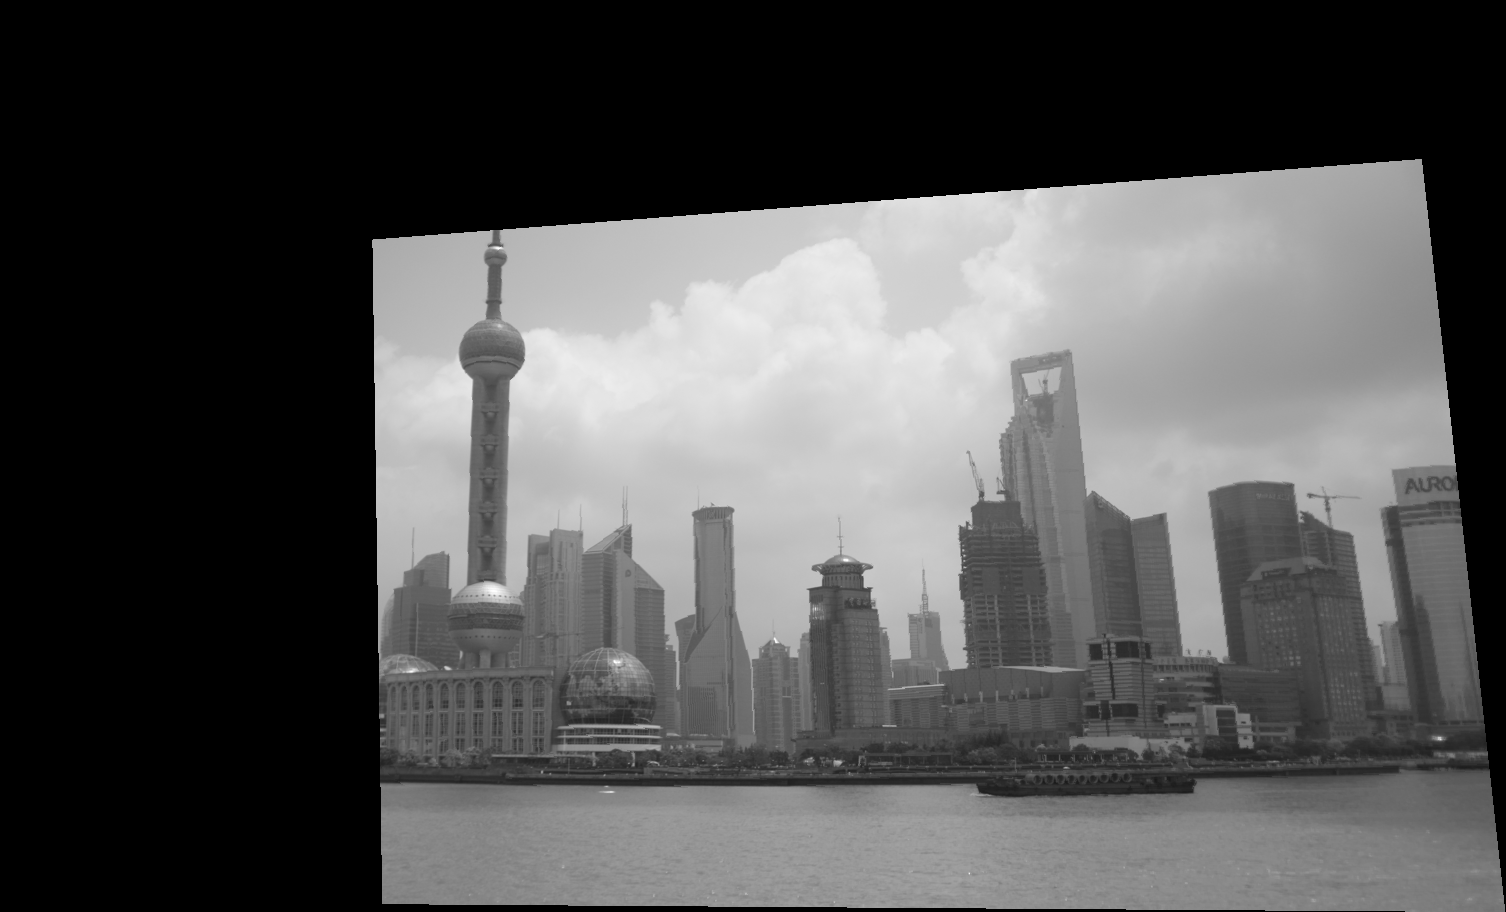

In [ ]:
cv2_imshow(img_final2)

In [ ]:
img_final2 = cv2.normalize(img_final2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [ ]:
img_final3=np.zeros((height_max,width_max,3))

(896, 1072, 3) (896, 1072, 3)


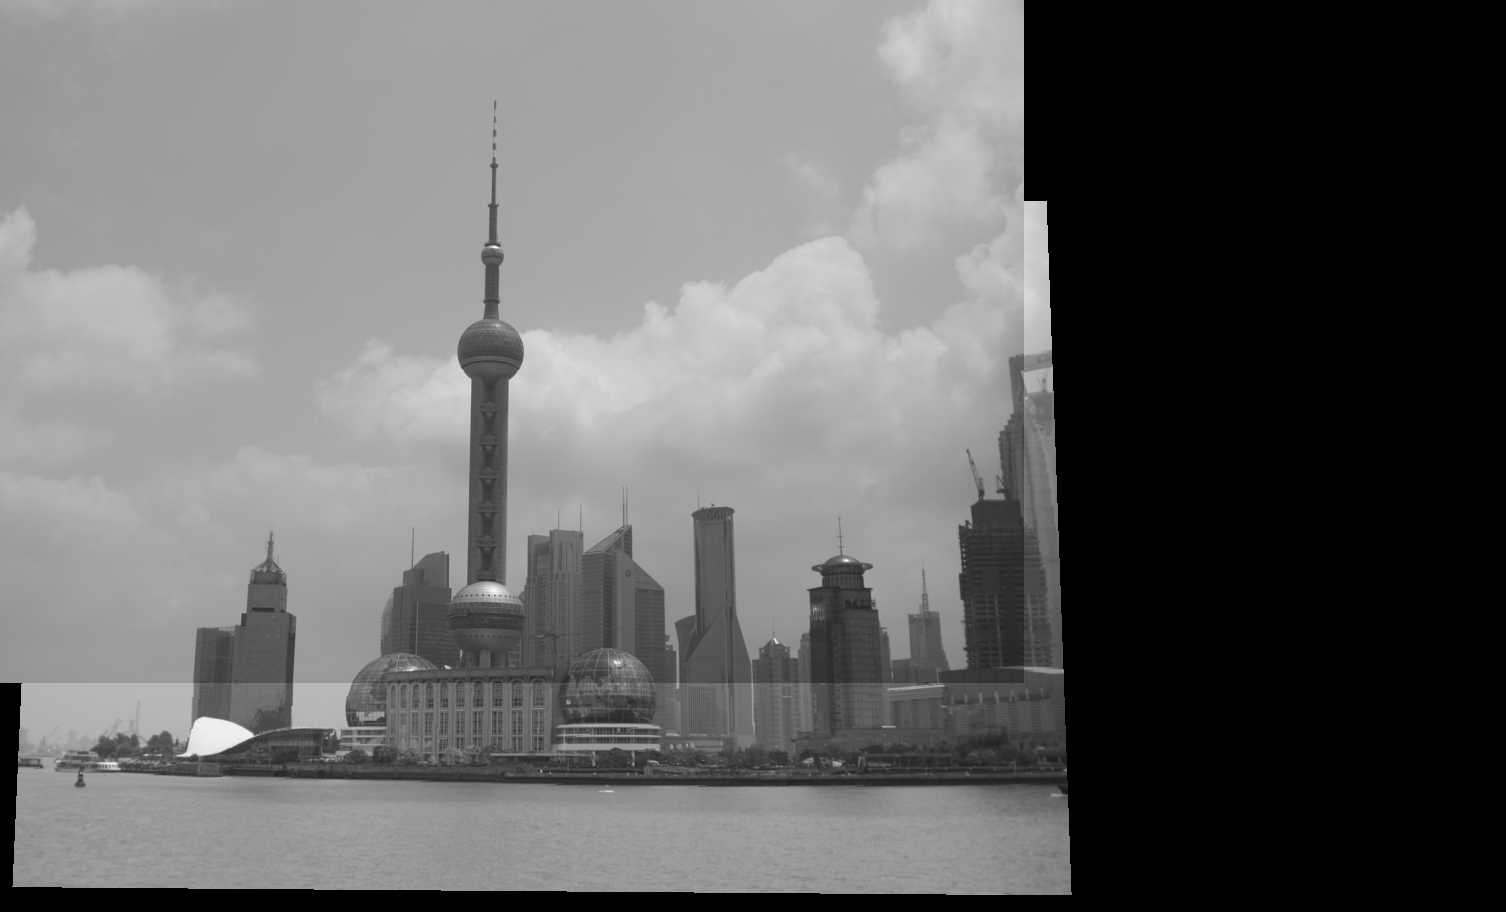

In [ ]:
rows,cols,channels = img_final.shape
roi = img_final3[0:rows, 0:cols]
# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img_final,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img_final,img_final,mask = mask)
# Put logo in ROI and modify the main image
print(img1_bg.shape,img2_fg.shape)
dst = cv2.add(img1_bg,img2_fg,dtype=cv2.CV_64F)
img_final3[0:rows, 0:cols ] = dst
cv2_imshow(img_final3)



(912, 1506, 3) (912, 1506, 3)


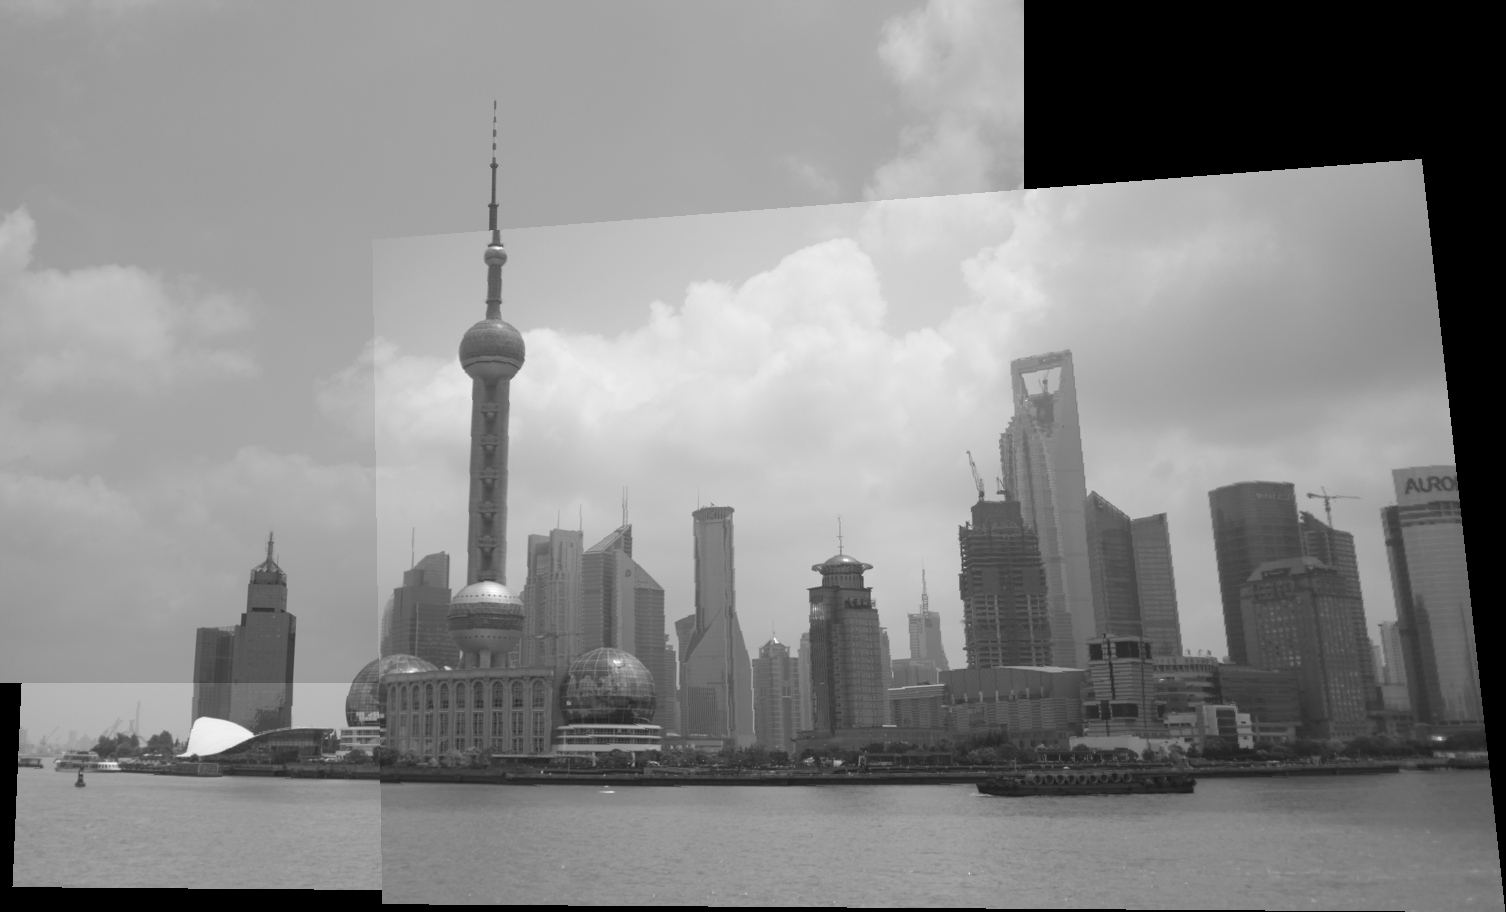

In [ ]:
rows,cols,channels = img_final2.shape
roi = img_final3[0:rows, 0:cols]
# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img_final2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img_final2,img_final2,mask = mask)
# Put logo in ROI and modify the main image
print(img1_bg.shape,img2_fg.shape)
dst = cv2.add(img1_bg,img2_fg,dtype=cv2.CV_64F)
img_final3[0:rows, 0:cols ] = dst
cv2_imshow(img_final3)

